<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [ ]:
%%capture
pip install pyswarms

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [ ]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [ ]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [ ]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [ ]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [ ]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [ ]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [ ]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [ ]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [ ]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    cmp_f = dist[s]
    return cmp_f

In [ ]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


In [ ]:
def objective_st(x):

    # Criação de variáveis para os parâmetros
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cálculo da intensidade de falha
    # Cria as variaveis
    # tempos de falhas
    t = df['t']
    # indice do sistema
    k = df['k']
    m = k.drop_duplicates().shape[0]
    # Numero de ciclos de manutenção
    ck = df['c'].max()
    # Numero de falhas e severidade das manutenções preventivas em cada sistema
    n = []
    s = []
    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s.append(list(df['s'][k * ck:(k + 1) * ck]))

    # Tempos das MP
    T = list(df['T'][:m])

    # Cria alguns cenários de teste
    beta = 5

    solucao = [lamb, beta, theta]

    # Cria a instância da classe IntensidadeFalha
    falha = IntensidadeFalha()

    # Inicializa a instância com os valores necessários
    falha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

    # Cria os dados da intensidade de falha
    falha.create()

    # Cálculo do custo total
    custo_total = 0
    for ui in falha.u:
        if not np.isnan(ui).any(): #  Para verificar se há algum valor NaN no array
            custo_total += CMP + (CMC * (1 - np.exp(-lamb * ui)))

    custo_total = np.minimum(custo_total, MAX_VALUE_CUSTO)  # Corrigido para limitar o valor ao máximo permitido

    return custo_total

In [ ]:
num_particles = 50
max_iterations = 50

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=50, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)
pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)


2023-06-30 04:43:44,965 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1e+4
2023-06-30 04:43:45,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10000.0, best pos: [0.60777576 0.1292451  0.47167801 0.11264704 0.85260806 0.62706769
 0.66024651 0.92893003 0.03028376 0.33189231 0.22106649 0.07318424
 0.44368056 0.85158161 0.69887814 0.73753892 0.05696989 0.33568356
 0.34404225 0.62379615 0.38683334 0.09026501 0.13902216 0.13267195
 0.70495883 0.50492655 0.52129653 0.99357244 0.92678528 0.72064022
 0.40434093 0.39656402 0.34981992 0.56196648 0.2308459  0.98810715
 0.44488473 0.55206027 0.27654859 0.91222637 0.61588332 0.43825781
 0.1426314  0.53803038 0.27724123 0.07983644 0.83982915 0.53686973
 0.91229974 0.70032707]
2023-06-30 04:43:45,638 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.si

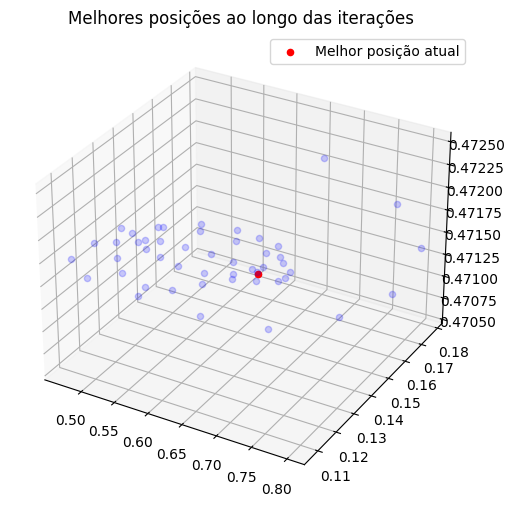

                              
                              
*************************************************************************
Número total de iterações: 50
Número de Particulas: 50
                              
Melhor posição: 0.677809681723978
Melhor custo: 10000.0
Melhor custo pessoal (pbest) de cada partícula: 10000.0
*************************************************************************


In [ ]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("                              ")
print("Melhor posição:", best_position[0])
print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])
print("*************************************************************************")

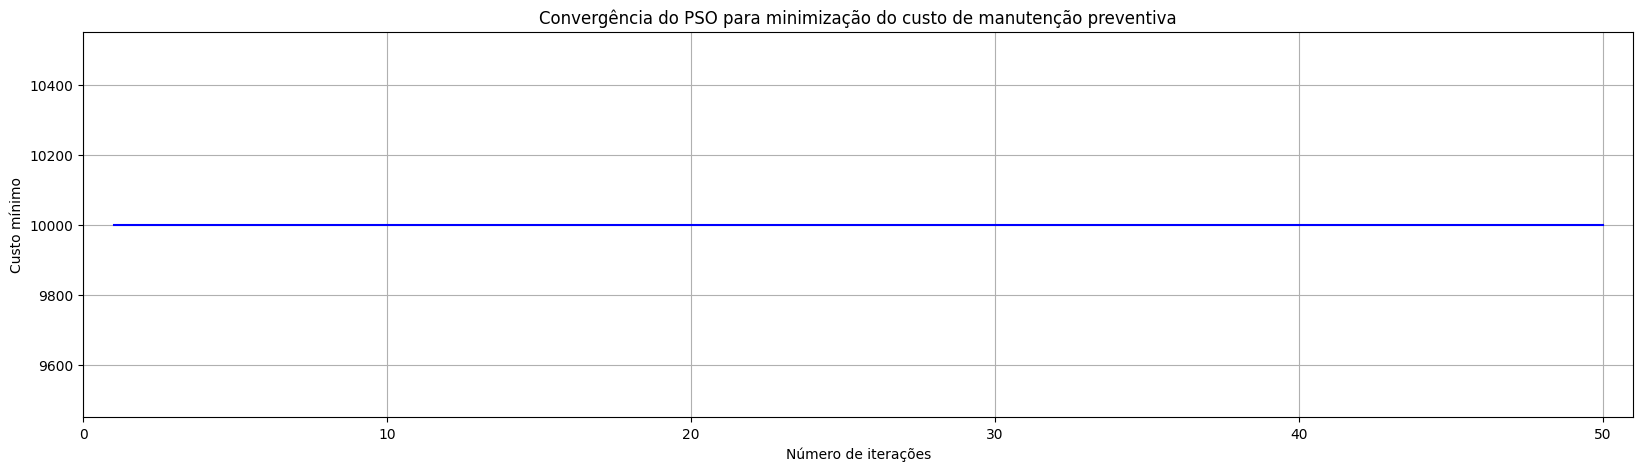

In [ ]:
# Plota o gráfico do custo em função do número de iterações
fig_verify = plt.figure(figsize=(20, 5))
plt.plot(range(1, max_iterations+1), pbest_cost, color="blue")  # Alterado para pbest_cost
plt.xlabel('Número de iterações')
plt.ylabel('Custo mínimo')
plt.title('Convergência do PSO para minimização do custo de manutenção preventiva')
plt.xlim(0, max_iterations+1)  # Define os limites do eixo x
plt.grid(True)
plt.show()